In [1]:
#i was getting a: "CUDA out of memory".
# import torch
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device = None, abbreviated=False)

# import gc
# del variables
# gc.collect()

In [2]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [4]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')
export_path.ls()

(#3) [Path('/content/gdrive/MyDrive/Colab Notebooks/smartphones_ddg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Untitled0.ipynb'),Path('/content/gdrive/MyDrive/Colab Notebooks/digits')]

In [5]:
path = export_path/'digits'
path.ls()

(#2) [Path('/content/gdrive/MyDrive/Colab Notebooks/digits/valid'),Path('/content/gdrive/MyDrive/Colab Notebooks/digits/train')]

In [6]:
# def get_parent_as_list(x):
#   return [parent_label(x)]

In [7]:
set_seed(21,True) 
fingers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=GrandparentSplitter(),#RandomSplitter(),
    get_y=parent_label,    
    item_tfms = Resize(640),
    #batch_tfms=aug_transforms(batch = 32, pad_mode="reflection")#, do_flip = True, flip_vert=True, max_lighting=0.75, p_lighting=0.4)) #to achieve results, sacrifices must be made.
    #My condolosenses to the real ones 
    batch_tfms=aug_transforms(size=420,align_corners=True,do_flip=True, max_lighting=0.4, p_lighting=0.2)) #changed batch size to be not hit cap


In [8]:
# DataBlock is a template to create DataLoaders
dls = fingers.dataloaders(path, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [9]:
#show_batch(fingers, unique = True, max_n = 9)

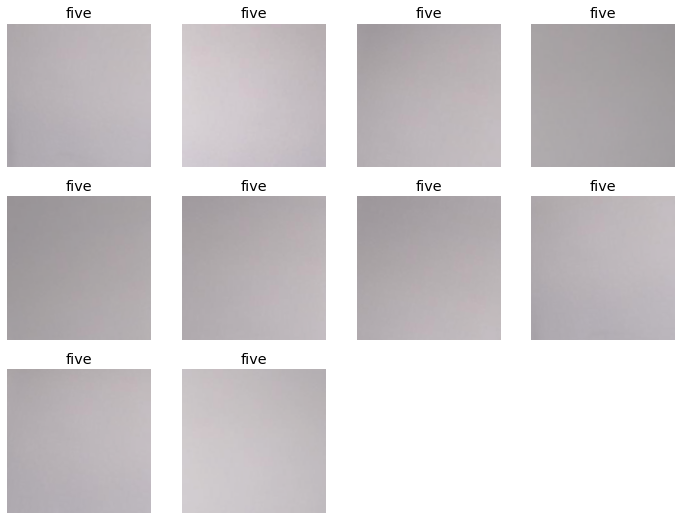

In [10]:
dls.train.show_batch(max_n=10, unique = True)

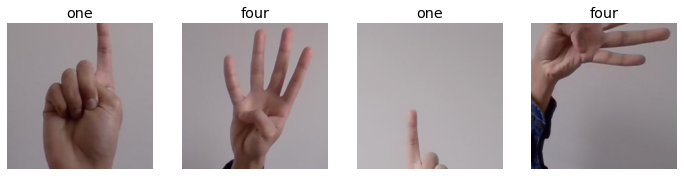

In [11]:
#unique = True is making stuff wack...
dls.train.show_batch(max_n=4, nrows=1)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.
To th best of my knowledge, accurate models are created with very large sets of data. Unfortunately we can only take so many pictures of our fingers. 

To make the training set more reliable, and to provide the validation set a more rigorous set of data, i thought it would be best to provide augmentations that change the data according to what I could not change. 

In that sense, it would be best to change the:

-lighting of the image

-the orientation of the image

-flipping the image

-changing the lighting of the image (to account for situations with lower lights or too much light).

-changing the pixel density to account for cameras with lower MP.

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?
There is only so many ways we can change the data. It would be best to test with hands of different sizes and colors to make a more reliable dataset. 

The best we can do with image augmentation is to change the lighting and saturation.

It should also be noted that since I did not provide an equal number of samples for each finger, my data could prove to be a bit skewed and uneven. 

I also did not position my hands correctly the first time around (should have been within the center of the frame).

# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

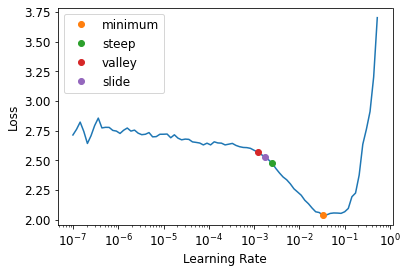

In [12]:
set_seed(21, True)
learn = cnn_learner(dls, resnet18, metrics=accuracy)#partial(accuracy_multi, thresh=0.2))
#lr_inital = learn.lr_find()
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#learn.lr_find()
# learn.fine_tune(2)
# learn.lr_find()
# learn.fit_one_cycle(6, lr_max=1e-5)

In [13]:
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")
#print(f"Minimum/10:\t{lr_min:.2e}\nSteepest Point:\t{lr_steep:.2e}\nLongest Valley:\t{lr_valley:.2e}\nSlide Interval:\t{lr_slide:.2e}")

Minimum/10:	3.31e-03
Steepest point:	2.51e-03
Longest valley:	1.20e-03
Slide interval:	1.74e-03


In [15]:
learn.fit_one_cycle(8, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.385255,2.433825,0.139344,00:27
1,2.184557,1.426551,0.434426,00:18
2,1.848518,1.084090,0.606557,00:18
3,1.581988,0.844679,0.713115,00:18
4,1.415624,0.812555,0.704918,00:17
5,1.241834,0.768983,0.688525,00:18
6,1.135342,0.787974,0.688525,00:18
7,1.041733,0.764787,0.688525,00:17


### Question 3: How did you select the number of epochs and learning rates? 
Learning rate: I used lr.find to find the best learning rate. I chose a learning rate slightly smaller than the steepest because it felt like a suitable decision.

Epochs: Chose an epoch up until where the accuracy was increasing and the losses were decreasing.

## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 
*YOUR ANSWER HERE*


# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

# 5. Summary and Conclusion

Summarize:
- Augmentations used
- Training strategy, including batch size, number of epochs and learning rates.
- Accuracy achieved, summary of confusion matrix

*YOUR ANSWER HERE*


Conclusion:
- Are you satisfied with model performance? Why, why not?

*YOUR ANSWER HERE*


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

*YOUR ANSWER HERE*
